# Token Distribution Analysis

This notebook analyzes the token distribution of the Airflow DAG dataset to ensure it fits within model context windows.

## 📋 Setup Note

**This notebook is designed to run locally** (not in Colab). To set it up:

```bash
# From project root
pip install -e ".[research]"
pip install jupyter

# Launch Jupyter and select the venv kernel
jupyter notebook
```

Make sure you're using the Python kernel from your virtual environment to ensure all imports work correctly.

In [3]:
%%capture
!pip install datasets transformers matplotlib seaborn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer

In [4]:
# Configuration
DATASET_ID = "andrea-t94/airflow-dag-dataset"  # Replace with your actual dataset ID
MODEL_ID = "Qwen/Qwen2.5-Coder-1.5B-Instruct"  # Using the target model's tokenizer
SPLIT = "train"

In [5]:
# Load Dataset and Tokenizer
print(f"Loading dataset: {DATASET_ID}...")
dataset = load_dataset(DATASET_ID, split=SPLIT)

print(f"Loading tokenizer: {MODEL_ID}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

Loading dataset: andrea-t94/airflow-dag-dataset...
Loading tokenizer: Qwen/Qwen2.5-Coder-1.5B-Instruct...


In [6]:
def analyze_row(row):
    messages = row['messages']
    user_content = next((m['content'] for m in messages if m['role'] == 'user'), "")
    assistant_content = next((m['content'] for m in messages if m['role'] == 'assistant'), "")
    
    # Accurate token counting
    user_tokens = len(tokenizer.encode(user_content))
    assistant_tokens = len(tokenizer.encode(assistant_content))
    total_tokens = user_tokens + assistant_tokens
    
    return {
        "user_tokens": user_tokens,
        "assistant_tokens": assistant_tokens,
        "total_tokens": total_tokens
    }

print("Analyzing tokens (this might take a moment)...")
analysis_ds = dataset.map(analyze_row)

Analyzing tokens (this might take a moment)...


Map:   0%|          | 0/7414 [00:00<?, ? examples/s]

In [7]:
# Convert to lists for statistics
user_lens = analysis_ds['user_tokens']
assistant_lens = analysis_ds['assistant_tokens']
total_lens = analysis_ds['total_tokens']

def print_stats(name, data):
    print(f"\n{name} Statistics:")
    print(f"  Mean:   {np.mean(data):.2f}")
    print(f"  Median: {np.median(data):.2f}")
    print(f"  Min:    {np.min(data)}")
    print(f"  Max:    {np.max(data)}")
    print(f"  P90:    {np.percentile(data, 90):.2f}")
    print(f"  P95:    {np.percentile(data, 95):.2f}")
    print(f"  P99:    {np.percentile(data, 99):.2f}")

print_stats("Prompt (User)", user_lens)
print_stats("Response (Assistant)", assistant_lens)
print_stats("Total Context", total_lens)


Prompt (User) Statistics:
  Mean:   50.81
  Median: 54.00
  Min:    5
  Max:    145
  P90:    64.00
  P95:    67.00
  P99:    74.00

Response (Assistant) Statistics:
  Mean:   900.12
  Median: 712.00
  Min:    45
  Max:    7515
  P90:    1828.00
  P95:    2261.00
  P99:    2845.00

Total Context Statistics:
  Mean:   950.93
  Median: 758.00
  Min:    65
  Max:    7574
  P90:    1886.70
  P95:    2318.35
  P99:    2910.22


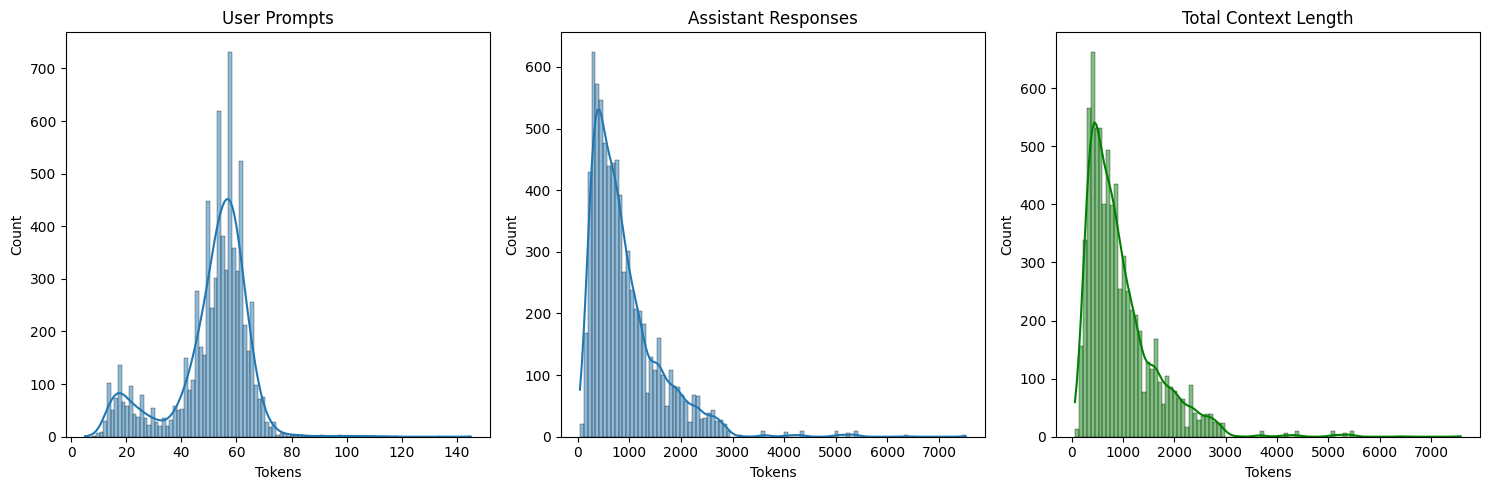

In [8]:
# Visualizations
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(user_lens, kde=True)
plt.title("User Prompts")
plt.xlabel("Tokens")

plt.subplot(1, 3, 2)
sns.histplot(assistant_lens, kde=True)
plt.title("Assistant Responses")
plt.xlabel("Tokens")

plt.subplot(1, 3, 3)
sns.histplot(total_lens, kde=True, color='green')
plt.title("Total Context Length")
plt.xlabel("Tokens")

plt.tight_layout()
plt.show()